In this assignment, you need to analyze a large set of customer reviews and come up with recommendations to the Singapore Airlines CEO to improve customer satisfaction.

The notebook serves as a starting point for your analysis.

At the end of the assignment, you should deliver a five-slide "elevator pitch" to the CEO summarizing your findings and recommendations, backing up your claims with analyses.

# Topic Modeling with Transformers

We have seen that transformers are a powerful tool to build encodings of text that capture context, order of words, etc... Typically, one uses a pre-trained transformer to produce the encodings, and then feeds these to their own model (e.g. a neural network) to solve their particular NLP task, like sentiment analysis or sequence labeling.

In this notebook, you will solve another NLP task called topic analysis (more on that later). You will use the BERTopic package for this task, which is built on top of HuggingFace transformers.

With BERTopic, you will analyze a dataset of Singapore Airlines customer reviews to gain insight into how to improve the customer experience.

You can find an expansive description of the dataset here
https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

We load the data and output some summary of the data columns.

In [ ]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [ ]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [ ]:
## If you want to see more text from the review, you can increase the display.max_colwidth

#pd.set_option('display.max_colwidth', 50)

## Quick summary statistics and visualizations

Let's look at some summary statistics for our dataset. For example, are there any interesting trends, or relationships between the length of reviews, presence of specific words, and ratings.

In [ ]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

# Preparing data for visualization
# We'll aggregate data to see if there's a visible trend between the length of reviews, presence of specific words, and ratings
aggregated_data = df.groupby('rating').agg({
    'review_length': 'mean',
    'contains_excellent': 'mean',
    'contains_terrible': 'mean'
}).reset_index()

aggregated_data

,rating,review_length,contains_excellent,contains_terrible
0,1,920.468307,0.021760,0.096500
1,2,871.423573,0.053407,0.071823
2,3,737.867195,0.080278,0.042616
3,4,526.661922,0.149466,0.006101
4,5,431.168326,0.222345,0.002028


Negative reviews might be longer because people explain what went wrong in detail, while positive reviews are often brief

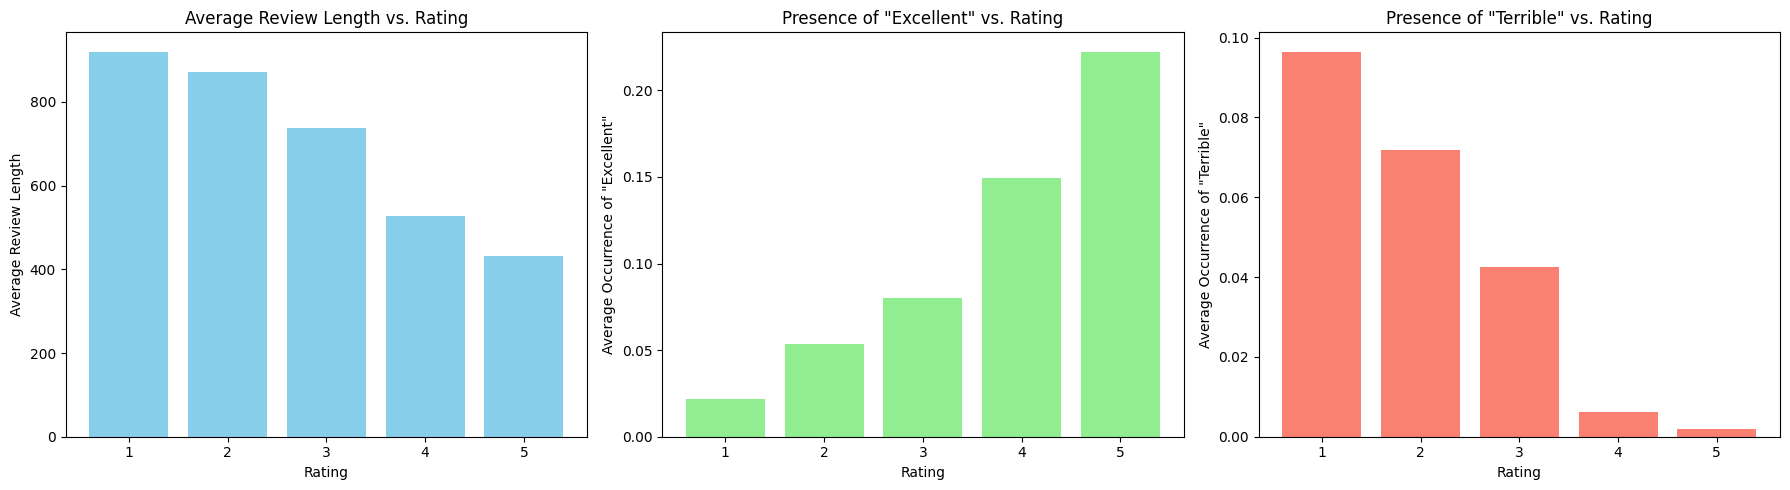

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Review length vs. rating
axes[0].bar(aggregated_data['rating'], aggregated_data['review_length'], color='skyblue')
axes[0].set_title('Average Review Length vs. Rating')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Average Review Length')

# Presence of "excellent" vs. rating
axes[1].bar(aggregated_data['rating'], aggregated_data['contains_excellent'], color='lightgreen')
axes[1].set_title('Presence of "Excellent" vs. Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Average Occurrence of "Excellent"')

# Presence of "terrible" vs. rating
axes[2].bar(aggregated_data['rating'], aggregated_data['contains_terrible'], color='salmon')
axes[2].set_title('Presence of "Terrible" vs. Rating')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Average Occurrence of "Terrible"')

plt.tight_layout()
plt.show()

We next aggregate the data by year, and plot how the ratings have changed over time.


In [ ]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,1352,0,0,2024
1,2024-03-11 23:39:13+00:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,4666,1,0,2024
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,420,0,0,2024
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,144,0,0,2024
4,2024-03-10 09:34:18+00:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,582,0,0,2024


In [ ]:
# Get the most recent review date
last_review_date = df['published_date'].max()
print("Last review date:", last_review_date)


Last review date: 2024-03-12 18:41:14+00:00


In [ ]:
aggregated_data = df.groupby('year').agg({
    'rating': 'mean',
}).reset_index()

aggregated_data

,year,rating
0,2018,4.319710
1,2019,4.246012
2,2020,4.046103
3,2021,2.435294
4,2022,2.181159
5,2023,2.684112
6,2024,2.333333


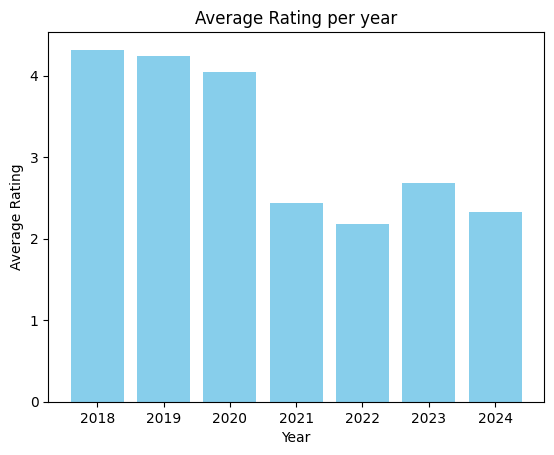

In [ ]:
plt.bar(aggregated_data['year'], aggregated_data['rating'], color='skyblue')
plt.title('Average Rating per year')
plt.xlabel('Year')
plt.ylabel('Average Rating')

plt.show()

# Ooops...

There seems to be a meaningful drop in ratings from 2021 onwards. Imagine you report to the Singapore Airlines CEO and you need to formulate a plan of action to improve this situation. It would be nice to see what has gone wrong.

Fortunately, you have the review data that may contain some information about what could be going wrong. This is where topic modeling comes in to help. In short, [topic modeling is a technique that allows you to extract "topics" that occur in a large collection of text](https://en.wikipedia.org/wiki/Topic_model). In this notebook, you will use BERTopic, a topic modeling package built on top of HuggingFace transformers.

Your task is to use BERTopic to explain the negative shift in ratings, and then present your findings as a one-slide pitch that you will present in class.

First, load up BERTopic and familiarize yourselves with its functionality.

# Topic analysis using BERTopic

In this assignment, you will not need to build a transformer per se. What you will do is use an ML package that uses a pre-trained transformer to solve a specific NLP task. In this case, that is topic modeling.

First, if running on Colab (which is highly recommended at least for creating your topic model), you will need to install the package:

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from bertopic import BERTopic

In [ ]:
#topic_model = BERTopic(embedding_model = 'all-MiniLM-L6-v2')

It can take a long time to train the topic model on the entire dataset. To reduce the load, we slice the dataset by year 2019 and run training.

Also, note that so far we are not making any specifications about the training process. The [documentation for BERTopic](https://maartengr.github.io/BERTopic/index.html) gives lots of information on how to tweak the fitting behavior (and how to access different [embeddings](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html), etc.). It also pays to take a look at the [best practices](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html).

In [ ]:
#df_slice = df[(df['year'] == 2019)]

In [ ]:
#topics, probs = topic_model.fit_transform(df_slice['text'])

Ok, let's see what this topic_model has to say. The following command returns the list of topics ordered by frequency. You can also see the most relevant words for the topic, and the most relevant reviews.

Note: topic -1 is a dummy topic and should generally be ignored. It aggregates all the outliers and reviews that couldn't be clustered into a topic.

In [ ]:
#topic_model.get_topic_info()

You can also obtain information on a specific topic. For example below you can look into topic 2 and get the top words for that topic. The numbers on the right quantify the importance of those words to the topic.

In [ ]:
#topic_model.get_topic(2)

Here, you can get representative reviews for a topic.

In [ ]:
#topic_model.get_representative_docs(2)

You can also visualize topic relationships in 2d space.

In [ ]:
#topic_model.visualize_topics()

Or visualize topic word scores.

In [ ]:
#topic_model.visualize_barchart()

Finally, it is often handy to visualize the term rank, to see clearly which topics have a particular focus on just a few words.

In [ ]:
#topic_model.visualize_term_rank()


Let's organize the topics and reviews in a dataframe.

In [ ]:
#topic_df = pd.DataFrame({"topic": topics, "document": df_slice['text']})
#topic_df

# Your Task

Use BERTopic (as well as additional tools you deem useful) to arrive at a set of explanations for the drop in ratings, and a corresponding set of recommendations to the CEO.

You can consult any resources to find out about more of the functionality of BERTopic.

As an example of something you could do, try to slice the data, say by year. What happens when rerun the topic model on the data slice? Is there any menaingful information that comes out?

In general, this is an open-ended exercise. Be creative!

# Deliverables

See the assignment descriptions for a full overview of the deliverables.

# Your analysis

In [ ]:
# Write your code here

In [ ]:
# Load Libraries

import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
from umap import UMAP
from hdbscan import HDBSCAN
import random
import numpy as np
import torch
import umap
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Preprocessing

In [ ]:
# Define custom stopwords
custom_stopwords = stopwords.words('english') + ['singapore', 'airline', 'airways', 'flight']

# Define the vectorizer with the adjusted stopwords
vectorizer_model = CountVectorizer(
    stop_words=custom_stopwords,
    ngram_range=(1, 3)  # Consider unigrams, bigrams, and trigrams
)


In [ ]:
# Function to clean text
def preprocess_text(text):
    if pd.isna(text):  # Handle missing values
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W+', ' ', text)  # Remove special characters

    sentences = sent_tokenize(text)  # Segment into sentences

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))  # Default stopwords list

    # Function to clean each sentence
    def clean_sentence(sentence):
        tokens = word_tokenize(sentence)  # Tokenize each sentence
        clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return " ".join(clean_tokens)

    # Apply cleaning to each sentence
    clean_sentences = [clean_sentence(sentence) for sentence in sentences]

    # Join sentences back into a clean review
    return " ".join(clean_sentences)


df['clean_text'] = df['text'].apply(preprocess_text)

# Apply the vectorizer to the cleaned text (e.g., for topic modeling or clustering)
X = vectorizer_model.fit_transform(df['clean_text'])

# **Analyisis Steps**

**1. Year-by-Year Topic Modeling with BERTopic**

**Step 1:** I first fitted a BERTopic model on the dataset year by year (2019-2024) to examine the evolution of topics over time. This allowed me to understand how customer concerns have changed over the years and to identify any emerging patterns or shifts in passenger feedback.

**2. Grouping Reviews into Two Periods (High and Low Ratings)**

**Step 2:** To simplify the analysis and focus on key trends, I grouped the reviews into two distinct periods:

* High-Review Period (2018-2020): Where the average ratings were high (above 4), indicating strong performance.

* Low-Review Period (2021-2023): Where ratings dropped significantly (below 2.5), likely due to factors such as the COVID-19 pandemic.

* This approach allowed for easier comparison of how customer concerns evolved during a period of high satisfaction vs. a period of low satisfaction.

**3. Focus on Low-Rated Reviews (Rating ≤ 3) from 2021-2024**

**Step 3:** I then examined the Top 10 Low-Rated Topic Percentages from 2021 to 2024, focusing specifically on reviews with ratings ≤ 3. This helped highlight the main issues causing dissatisfaction during this period.

**4. Reviewing Specific Low-Rated Topics in Detail**

**Step 4:** For a deeper understanding, I analyzed these low-rated topics by:

* Reviewing examples of low-rated reviews within each topic, which helped clarify the specific customer grievances.

* Analyzing the ratings of certain words and the frequency of mentions of specific terms related to the topics, which helped quantify the significance of each concern.

* Plotting the distribution of review ratings over time for these topics, providing a visual representation of how customer dissatisfaction evolved for specific issues.

**5. Comparing Low-Rated Topics with High-Rated Reviews (2018-2020)**

**Step 5:** To ensure a clear comparison, I focused on taking the insights gathered from the period 2021-2024 (where customer dissatisfaction was high) and applied them to the 2018-2020 period (when reviews were generally positive). I identified the key topics and words driving dissatisfaction in 2021-2024 and then examined how those same topics and words appeared in the high-rated reviews of 2018-2020.

This allowed me to directly compare:

- Which concerns from 2021-2024 (e.g., customer service, seat comfort) were also present in the 2018-2020 reviews.

- How these topics were discussed in positive versus negative contexts, highlighting areas where customer expectations may have shifted over time.

- For instance, I examined whether certain concerns were more prominent in negative reviews in the later period (2021-2024) compared to the earlier period (2018-2020), specifically around customer service and seat comfort.

## Lets look at year 2019

In [ ]:
# Slice year 2019 and see number of reviews
df_slice19 = df[(df['year'] == 2019)]
df_slice19.shape[0]

5203

In [ ]:
#!pip install --upgrade huggingface_hub sentence-transformers
#!pip install hf_xet

In [ ]:
# Add suitable embedding
embedding_model19 = "sentence-transformers/paraphrase-MiniLM-L12-v2"
model = AutoModel.from_pretrained(embedding_model19)
tokenizer = AutoTokenizer.from_pretrained(embedding_model19)

# UMAP for dimensionality reduction before clustering
umap_model19 = umap.UMAP(n_neighbors=30, n_components=10, min_dist=0.3, metric='euclidean', random_state=42, n_jobs=1)

# Optimize clustering with HDBSCAN
hdbscan_model19 = HDBSCAN(min_cluster_size=10, min_samples=3, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new19 = BERTopic(
    embedding_model=embedding_model19,
    umap_model=umap_model19,
    hdbscan_model=hdbscan_model19,
    n_gram_range=(1, 4),
    vectorizer_model=vectorizer_model,
    top_n_words=30,
    nr_topics='auto',
    verbose=True
)


In [ ]:
# Fit model
topics, probs = topic_model_new19.fit_transform(df_slice19['clean_text'])

2025-04-10 11:22:10,656 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/163 [00:00<?, ?it/s]

2025-04-10 11:22:19,324 - BERTopic - Embedding - Completed ✓
2025-04-10 11:22:19,325 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 11:23:05,578 - BERTopic - Dimensionality - Completed ✓
2025-04-10 11:23:05,579 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 11:23:06,031 - BERTopic - Cluster - Completed ✓
2025-04-10 11:23:06,032 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 11:23:08,385 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:08,396 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 11:23:08,414 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 11:23:11,026 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:11,042 - BERTopic - Topic reduction - Reduced number of topics from 47 to 8


In [ ]:
# Visualize topics
topic_model_new19.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice19['topic'] = topics
topic_ratings_2019=df_slice19.groupby('topic')['rating'].mean().sort_index()
topic_ratings_2019

,rating
topic,
-1,4.310365
0,4.060777
1,4.815789
2,4.527778
3,4.666667
4,4.187500
5,4.727273
6,4.600000


In [ ]:
# View top 10 words for each topic
topics = topic_model_new19.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: service, food, seat, good, time, staff, great, class, economy, crew
Topic 0: seat, service, food, time, good, economy, class, one, meal, hour
Topic 1: service, food, great, good, staff, friendly, excellent, comfortable, seat, class
Topic 2: toilet, clean, comfortable, good, service, food, cleaned, seat, always, throughout
Topic 3: sia, service, always, crew, time, best, flying sia, good, experience, flying
Topic 4: wheelchair, staff, mom, always, check, husband, boarding, board, service, airport
Topic 5: child, amazing, carrying, crew, cabin crew, 12, cabin, car seat, kid, also
Topic 6: movie, friendly, great, nice, choice, also, great choice, staff, amount, well


In [ ]:
topic_model_new19.visualize_topics()

In [ ]:
topic_model_new19.visualize_term_rank()

## Lest now check year 2020

In [ ]:
# Slice year 2019 and see number of reviews
df_slice20 = df[(df['year'] == 2020)]
df_slice20.shape[0]

911

In [ ]:
# Add embedding
embedding_model20 = SentenceTransformer("paraphrase-MiniLM-L12-v2")

# UMAP for dimensionality reduction before clustering
umap_model20 = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='euclidean',
                      random_state=42)
# Optimize clustering with HDBSCAN
hdbscan_model20 = HDBSCAN(min_cluster_size=10, min_samples=3, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new20 = BERTopic(
    embedding_model=embedding_model20,
    umap_model=umap_model20,
    hdbscan_model=hdbscan_model20,
    n_gram_range=(1, 3),  # Allow phrases
    vectorizer_model=vectorizer_model,
    top_n_words=15,  # More descriptive topics
    nr_topics='auto',  # Automatically determine the best number of topics
    verbose=True
)

In [ ]:
# Fit model
topics, probs = topic_model_new20.fit_transform(df_slice20['clean_text'])

2025-04-10 11:23:16,904 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

2025-04-10 11:23:18,309 - BERTopic - Embedding - Completed ✓
2025-04-10 11:23:18,311 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 11:23:20,781 - BERTopic - Dimensionality - Completed ✓
2025-04-10 11:23:20,782 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 11:23:20,805 - BERTopic - Cluster - Completed ✓
2025-04-10 11:23:20,806 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 11:23:21,330 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:21,333 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 11:23:21,344 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 11:23:21,847 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:21,852 - BERTopic - Topic reduction - Reduced number of topics from 30 to 12


In [ ]:
# Visualize topics
topic_model_new20.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice20['topic'] = topics
topic_ratings_2020=df_slice20.groupby('topic')['rating'].mean().sort_index()
topic_ratings_2020

,rating
topic,
-1,3.969697
0,4.424710
1,2.322581
2,4.650000
3,2.380952
4,4.222222
5,4.500000
6,3.176471
7,4.764706


In [ ]:
# View top 10 words for each topic
topics = topic_model_new20.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: seat, service, class, passenger, good, food, business, time, cabin, one
Topic 0: food, service, good, seat, great, time, class, staff, crew, fly
Topic 1: refund, ticket, time, call, would, travel, day, get, said, cancelled
Topic 2: good, crew, cabin, service, seat, great, food, staff, always, nice
Topic 3: refund, month, covid, still waiting, money, week, cancelled, refunded, due, waiting
Topic 4: seat, a380, room, crew, new, mask, good, leg room, front, leg
Topic 5: food, good, food drink, staff, drink, entertainment, would, meal, service, drink excellent would
Topic 6: meal, passenger, sq, time, crew, food, child, klm, menu, seat
Topic 7: crew, attendant, food, service, good, staff, snack, like, drink, helpful
Topic 8: food, service, staff, great, good, everything, class, bed, business, wine
Topic 9: seat, nice, comfortable, legroom, good, tall, leg, well, space, service
Topic 10: good, comfortable, entertainment, great, food good, food, service, service good, food good cho

**Topics 1, 3  has < 3 rating. Lets look more closely into it**

In [ ]:
# Top words that are most representative for Topic 3
topic_model_new20.get_topic(3)

[('meal', np.float64(0.013302696831599025)),
 ('passenger', np.float64(0.012624168929894108)),
 ('sq', np.float64(0.012272835366089899)),
 ('time', np.float64(0.012129057382925775)),
 ('crew', np.float64(0.011075205022235666)),
 ('food', np.float64(0.010940025844210577)),
 ('child', np.float64(0.010454494256996346)),
 ('klm', np.float64(0.00906104103112782)),
 ('menu', np.float64(0.008796485230065574)),
 ('seat', np.float64(0.008372667979860035)),
 ('better', np.float64(0.008313505911687703)),
 ('service', np.float64(0.007888804487782305)),
 ('one', np.float64(0.007822416939819674)),
 ('back', np.float64(0.007696312575933851)),
 ('bed', np.float64(0.0076508967905029425))]

In [ ]:
# Display representative reviews
topic_model_new19.get_representative_docs(3)

['despite long travel nice drank much well course included plane clean maybe air conditioning bit strong taste blanket cover staff kind super smiling watched soooo many nice movie',
 'wonderful flight taken many budget airline work recently nice get back normal economy went smoothly boarding landing staff great friendly attentive food enjoyable overall service perfect economy well done seat comfy movie good eveything worked great flight would preference airline',
 'friendly smile welcomed onto plane got better load leg room constant offer juice water keep u hydrated snack needed well meal start end flight could need choice flight entertainment also excellent able see recent release managed see yet altogether excellent experience']

In [ ]:
# Top words that are most representative for Topic 2
topic_model_new20.get_topic(1)

[('good', np.float64(0.022831572206576563)),
 ('crew', np.float64(0.018817621569556308)),
 ('cabin', np.float64(0.017841457260495054)),
 ('service', np.float64(0.016401875273119752)),
 ('seat', np.float64(0.01625806188624331)),
 ('great', np.float64(0.015695312279759528)),
 ('food', np.float64(0.015102702706714384)),
 ('staff', np.float64(0.014733640381034791)),
 ('always', np.float64(0.01380960965049415)),
 ('nice', np.float64(0.013545920588878178)),
 ('comfortable', np.float64(0.012989791579114512)),
 ('cabin crew', np.float64(0.012975300532877489)),
 ('plane', np.float64(0.012040551977466354)),
 ('best', np.float64(0.01176482499929282)),
 ('one', np.float64(0.011297252666807466))]

In [ ]:
# Display representative reviews
topic_model_new20.get_representative_docs(2)

['wanted write note thanks crew board plane especially served last row buisness class service crew personable always ready help thoughtful personally person small appetite crew caught fact quickly offering needed later part flight said food great delicious favourite lemoncello gelato never eaten anything amazing even plane kudos chef also thoughtful gesture swop cup water bottled one sleep lest spill unknownly extension seat bed made good restful sleep flight always great able fly back home singapore board sq reassuring close heart flight also flight economy class seat',
 'inflight catering service taste good blanket provided every passenger without asking better flying cx cabin crew friendly pleasant however lack assistance airport need early check service completed online check day flight 6 30pm want spend sometime new airport arrived early around 3 15pm however spending half hour self drop bag print boarding pas airport due system error nice male staff helping 13 passenger group fin

There is a bit of overlap between these two topics.

Topic 2 poor experiences with customer service representatives while trying to resolve refund or booking issues — especially over the phone. Main complaints include:

- Long call wait times and unhelpful or rude staff

- Being passed between agents without resolution

- Contradictory information from different agents

- Confusion over responsibility between Singapore Airlines and third-party booking sites

Topic 1 is centered on frustration over delayed or unprocessed refunds, mostly stemming from flight cancellations due to COVID-19. Customers are angry about:

- Waiting for months without getting their money back

- Flights cancelled "due to COVID", but refunds not being processed

- Perceived lack of support or communication from customer service

There’s also emotion around financial stress and disappointment with how a premium airline is handling the situation. The language suggests that customers feel abandoned after cancellations and let down by the lack of accountability.



In [ ]:
topic_model_new20.visualize_topics()

In [ ]:
topic_model_new20.visualize_term_rank()

##Lets now look at year 2021

In [ ]:
df_slice21 = df[(df['year'] == 2021)]
df_slice21.shape[0]

85

In [ ]:
 # Add embedding
embedding_model21 = SentenceTransformer("paraphrase-MiniLM-L12-v2")

# UMAP for dimensionality reduction before clustering
umap_model21 = umap.UMAP(n_neighbors=8, n_components=2, min_dist=0.1, metric='euclidean',
                      random_state=42)
# Optimize clustering with HDBSCAN
hdbscan_model21 = HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new21 = BERTopic(
    embedding_model=embedding_model21,  # Stronger embeddings
    umap_model=umap_model21,  # Better topic separation
    hdbscan_model=hdbscan_model21,  # More robust clustering
    n_gram_range=(1, 3),  # Allow phrases
    vectorizer_model=vectorizer_model,
    top_n_words=15,  # More descriptive topics
    nr_topics='auto',  # Automatically determine the best number of topics
    verbose=True
)

In [ ]:
topics, probs = topic_model_new21.fit_transform(df_slice21['clean_text'])

2025-04-10 11:23:25,742 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-10 11:23:26,049 - BERTopic - Embedding - Completed ✓
2025-04-10 11:23:26,052 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 11:23:26,187 - BERTopic - Dimensionality - Completed ✓
2025-04-10 11:23:26,188 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 11:23:26,195 - BERTopic - Cluster - Completed ✓
2025-04-10 11:23:26,196 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 11:23:26,286 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:26,288 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 11:23:26,300 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 11:23:26,384 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:26,388 - BERTopic - Topic reduction - Reduced number of topics from 11 to 11


In [ ]:
topic_model_new21.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice21['topic'] = topics
topic_ratings_2021=df_slice21.groupby('topic')['rating'].mean().sort_index()
topic_ratings_2021

,rating
topic,
-1,3.722222
0,1.384615
1,1.545455
2,3.800000
3,1.500000
4,1.666667
5,1.000000
6,1.000000
7,4.500000


**Topics 2, 7 & 9 are the only ones with ratings >= 3**

In [ ]:
# View top 10 words for each topic
topics = topic_model_new21.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: service, get, people, covid, called, day, fly, back, staff, seat
Topic 0: customer service, customer, call, service, email, one, form, never, time, hour
Topic 1: ticket, change, month, 2021, extra, told, return, one, week, agent
Topic 2: seat, business, class, economy, business class, good, comfortable, cabin, food, service
Topic 3: visa, said, sq, transit, staff, transit visa, ac, told, airport, refused
Topic 4: back, time, 2020, got, seat, booked, book, hour, covid, last
Topic 5: hour, phone, called, would, customer, tried, result, get, via, company
Topic 6: booking, terminal, passenger, south africa, one booking, south, waiting room, africa, knew, transit
Topic 7: snack, airport, changi airport, sia, changi, drink, service, meal, sfo, served
Topic 8: hour, next, sydney, crew, time, offered, wait, first, arrange, time sydney
Topic 9: meal, pre, pre covid, service, covid, snack, ask, drink, crew, meal hour


Theese could be labeled as:

Topic 0: Customer Service & Communication Issues

Topic 1: Ticket Changes & Agent Support Problems

Topic 2: Seat Comfort & Cabin Experience

Topic 3: Transit & Visa Issues

Topic 4: Booking Problems During COVID-19

Topic 5: Delayed Phone Support & Unresolved Issues

Topic 6: Booking & Transit Confusion (Africa-Related)

Topic 7: Changi Airport Service & In-Flight Snacks

Topic 8: Delays, Wait Times & Crew Coordination

Topic 9: Meal & Beverage Service (Pre/Post-COVID)

In [ ]:
topic_model_new21.visualize_topics()

In [ ]:
topic_model_new21.visualize_term_rank()

## Next lets check year 2022

In [ ]:
df_slice22 = df[(df['year'] == 2022)]
df_slice22.shape[0]

552

In [ ]:
# Add embedding
embedding_model22 = SentenceTransformer("paraphrase-MiniLM-L12-v2")

# UMAP for dimensionality reduction before clustering
umap_model22 = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='euclidean',
                      random_state=42)
# Optimize clustering with HDBSCAN
hdbscan_model22 = HDBSCAN(min_cluster_size=10, min_samples=3, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new22 = BERTopic(
    embedding_model=embedding_model22,  # Stronger embeddings
    umap_model=umap_model22,  # Better topic separation
    hdbscan_model=hdbscan_model22,  # More robust clustering
    n_gram_range=(1, 3),  # Allow phrases
    vectorizer_model=vectorizer_model,
    top_n_words=15,  # More descriptive topics
    nr_topics=15,  # Automatically determine the best number of topics
    verbose=True
)

In [ ]:
topics, probs = topic_model_new22.fit_transform(df_slice22['clean_text'])

2025-04-10 11:23:28,374 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2025-04-10 11:23:29,550 - BERTopic - Embedding - Completed ✓
2025-04-10 11:23:29,551 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 11:23:30,875 - BERTopic - Dimensionality - Completed ✓
2025-04-10 11:23:30,877 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 11:23:30,892 - BERTopic - Cluster - Completed ✓
2025-04-10 11:23:30,892 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 11:23:31,276 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:31,279 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 11:23:31,286 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 11:23:31,710 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:31,714 - BERTopic - Topic reduction - Reduced number of topics from 16 to 15


In [ ]:
topic_model_new22.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice22['topic'] = topics
topic_ratings_2022=df_slice22.groupby('topic')['rating'].mean().sort_index()
topic_ratings_2022

,rating
topic,
-1,2.321951
0,2.425926
1,1.343284
2,1.240000
3,1.181818
4,1.350000
5,2.928571
6,3.692308
7,3.538462


**Topic 4 is the only one with good rating >4**

In [ ]:
# View top 10 words for each topic
topics = topic_model_new22.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: service, seat, time, sia, hour, class, business, one, would, food
Topic 0: service, meal, food, hour, time, economy, good, get, staff, even
Topic 1: ticket, change, refund, day, customer, booked, booking, call, money, time
Topic 2: customer, ticket, sq, time, service, email, seat, back, day, would
Topic 3: air, cancel, day, time, vienna, airport, hour, customer, cancelled, frankfurt
Topic 4: email, customer, customer service, get, phone, tried, 20k, name, book, time
Topic 5: seat, class, service, economy, food, one, definitely, meal, economy class, comfortable
Topic 6: crew, plane, seat, well, check, boarding, friendly, food, bit, seemed
Topic 7: class, good, crew, food, service, first, experience, economy class, seat, disembarkment
Topic 8: food, seat, class, meal, also, one, movie, hour, economy, good
Topic 9: melbourne, service, put, back, sq, experience, luggage, fly, nothing, foreigner
Topic 10: reserved seating, reserved, seating, worst, service, food, flown, given, goo

Lets label these topics

Topic 0: Service & Comfort

Topic 1: Booking & Refund Issues

Topic 2: Customer Service & Ticketing

Topic 3: Flight Cancellations & Delays

Topic 4: Customer Service Communication

Topic 5: Economy Class Experience

Topic 6: Crew & In-Flight Experience

Topic 7: Service Quality in Various Classes


Topic 8: Economy Class Food & Entertainment

Topic 9: Luggage & Service Experience Abroad

Topic 10: Reserved Seating & Poor Service

Topic 11: Ticketing & Airline Website Issues

Topic 12: Good In-Flight Experience

Topic 13: Customer Service Failures

In [ ]:
topic_model_new22.visualize_topics()

In [ ]:
topic_model_new22.visualize_term_rank()

## Year 2023

In [ ]:
df_slice23 = df[(df['year'] == 2023)]
df_slice23.shape[0]

535

In [ ]:
# Add embedding
embedding_model23 = SentenceTransformer("paraphrase-MiniLM-L12-v2")


# UMAP for dimensionality reduction before clustering
umap_model23 = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='euclidean',
                      random_state=42)

# Optimize clustering with HDBSCAN
hdbscan_model23 = HDBSCAN(min_cluster_size=3, min_samples=3, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new23 = BERTopic(
    embedding_model=embedding_model23,  # Stronger embeddings
    umap_model=umap_model23,  # Better topic separation
    hdbscan_model=hdbscan_model23,  # More robust clustering
    n_gram_range=(1, 3),  # Allow phrases
    vectorizer_model=vectorizer_model,
    top_n_words=15,  # More descriptive topics
    nr_topics=10,
    verbose=True
)

In [ ]:
topics, probs = topic_model_new23.fit_transform(df_slice23['clean_text'])

2025-04-10 11:23:33,335 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2025-04-10 11:23:34,479 - BERTopic - Embedding - Completed ✓
2025-04-10 11:23:34,481 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 11:23:35,786 - BERTopic - Dimensionality - Completed ✓
2025-04-10 11:23:35,788 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 11:23:35,804 - BERTopic - Cluster - Completed ✓
2025-04-10 11:23:35,805 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 11:23:36,228 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:36,231 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 11:23:36,240 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 11:23:36,698 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:36,703 - BERTopic - Topic reduction - Reduced number of topics from 47 to 10


In [ ]:
topic_model_new23.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice23['topic'] = topics
topic_ratings_2023=df_slice23.groupby('topic')['rating'].mean().sort_index()
topic_ratings_2023

,rating
topic,
-1,2.736559
0,2.422535
1,4.709677
2,3.166667
3,1.400000
4,3.500000
5,3.500000
6,2.000000
7,1.000000


**Topic 4 is the only one with good rating >4**

In [ ]:
# View top 10 words for each topic
topics = topic_model_new23.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: service, seat, food, meal, time, economy, crew, one, good, class
Topic 0: seat, service, economy, time, class, would, hour, one, get, food
Topic 1: good, food, service, staff, great, excellent, long, time, food good, crew
Topic 2: food, class, business, business class, best, worst, service, drink, friendly, crew
Topic 3: sia, refund, mile, customer, service, bank, told, request, elite mile, month
Topic 4: janice, food, special, nothing, served, supply particularly, stop particular service, worth seeing kind, sweet lady, sweet lady thank
Topic 5: sing, leg, bad, scoot, bkk sing, sing perth, bad food, bkk, meal, mel
Topic 6: cubicle, shower, time, delay, food, toilet, staff, capri, hotel, facility
Topic 7: stating, keep original, keep original ticket, original ticket, shown, upgrade, 00, original, keep, opposite answer
Topic 8: t2, five star, five, really, expectation, rice, high, cube, star, craft


lets label topics:

- Topic 0: General economy class experience (seat, food, service, time)

- Topic 1: Negative feedback on specific meals

- Topic 2: Very poor food quality in economy, including cleanliness (e.g., tray, toilet)

- Topic 3: Issues with frequent flyer miles and elite status not being credited

- Topic 4: Highly positive reviews focused on service and amenities (e.g., Wi-Fi, best service)

- Topic 5: Cabin and seat comfort, especially bulkhead seats and crew performance

- Topic 6: First class and suite experience (routes like SIN–LDN, lobster, gluten-free options)

- Topic 7: Trips negatively impacted by lost luggage or disruptions (e.g., JFK–Davao, Sydney)

- Topic 8: Poor premium economy and cabin service experience

In [ ]:
topic_model_new23.visualize_topics()

In [ ]:
topic_model_new23.visualize_term_rank()

In [ ]:
topic_model_new23.get_representative_docs(7)

['bag arrive 3 4 day give penny try entering right booking ref accept way',
 'booked flight 3 month advance ever since unending series email stating something changed breaking point received notification stating first leg departing hour late second leg would depart 5hrs sooner leaving less hour make connection upon requesting solution airline offered alternative option promptly confirming would happy option took week respond stating option longer available reason given stating give refund instead book another date travel flight gone since booked still result overall monetary loss taking refund booking another airline',
 'even gotten flight yet experience online booking system customer service rep already infuriating upgrade page shown price 0 00 upgrade business lite premium economy clicked complete upgrade shown different screen saying id paid approximately 2 000 per person immediately contact customer service 1 one could explain 0 00 cost shown meant actually mean 0 00 2 got opposite

## Year 2024


In [ ]:
df_slice24 = df[(df['year'] == 2024)]
df_slice24.shape[0]

96

In [ ]:
# Add embedding
embedding_model24 = SentenceTransformer("paraphrase-MiniLM-L12-v2")

# UMAP for dimensionality reduction before clustering
umap_model24 = umap.UMAP(n_neighbors=8, n_components=2, min_dist=0.1, metric='euclidean',
                      random_state=42)
# Optimize clustering with HDBSCAN
hdbscan_model24 = HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new24 = BERTopic(
    embedding_model=embedding_model24,  # Stronger embeddings
    umap_model=umap_model24,  # Better topic separation
    hdbscan_model=hdbscan_model24,  # More robust clustering
    n_gram_range=(1, 3),  # Allow phrases
    vectorizer_model=vectorizer_model,
    top_n_words=15,  # More descriptive topics
    nr_topics= 10 ,
    verbose=True
)

In [ ]:
topics, probs = topic_model_new24.fit_transform(df_slice24['clean_text'])

2025-04-10 11:23:39,391 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-04-10 11:23:39,771 - BERTopic - Embedding - Completed ✓
2025-04-10 11:23:39,772 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 11:23:40,010 - BERTopic - Dimensionality - Completed ✓
2025-04-10 11:23:40,013 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 11:23:40,026 - BERTopic - Cluster - Completed ✓
2025-04-10 11:23:40,029 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 11:23:40,142 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:40,143 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 11:23:40,150 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 11:23:40,219 - BERTopic - Representation - Completed ✓
2025-04-10 11:23:40,221 - BERTopic - Topic reduction - Reduced number of topics from 18 to 10


In [ ]:
topic_model_new24.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice24['topic'] = topics
topic_ratings_2024=df_slice24.groupby('topic')['rating'].mean().sort_index()
topic_ratings_2024

,rating
topic,
-1,3.444444
0,3.150000
1,1.800000
2,3.000000
3,1.454545
4,2.375000
5,1.428571
6,1.000000
7,2.333333


**No topics with rating >=4**

In [ ]:
# View top 10 words for each topic
topics = topic_model_new24.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: even, class, seat, penny, one, nice, provided, thank, hour, economy
Topic 0: seat, food, service, one, best, economy, much, would, crew, overall
Topic 1: customer, service, ticket, customer service, luggage, would, staff, hour, airport, time
Topic 2: suite, class, seat, cabin, service, crew, passenger, meal, lounge, drink
Topic 3: one, food, business, class, business class, meal, time, choice, horrible, could
Topic 4: economy, premium, premium economy, seat, extra, toilet, drink, upgrade, room, better
Topic 5: paid, upgrade, money, month, back, booked, hour, voucher, time, pay
Topic 6: ticket, another, sold, rebooking, agent, tell, hour, change, please, time
Topic 7: good, check, board, bag, jakarta, seoul, waitlist, early, night, every
Topic 8: customer care, booking, care, cancelled, customer, ticket, sq, assured, booking cancelled, airport denied


- Topic 0: Premium Economy Comfort Issues

- Topic 1: Customer Service and Airport Experience

- Topic 2: Payment and Upgrade Problems

- Topic 3: Suite Class Experience

- Topic 4: Premium Economy Drinks and Service

- Topic 5: Mixed Flight Experience

- Topic 6: Business Class Food Complaints

- Topic 7: Business Class Cleanliness and Decline in Standards

- Topic 8: Booking Issues and Cancellations

In [ ]:
topic_model_new24.visualize_term_rank()

In [ ]:
topic_model_new24.get_representative_docs(5)

['disabled bad experience sydney disability service check desk lady offered upgrade economy premium 380 said lot seat checked phone relevant department took money debit card issued new boarding pas way aircraft called back told fare originally paid allow upgrade paid fee offered singapore airline internet say order u block upgrade want upgrade please pay u money rather quoted price bizarre tell send money back within 10 working day basically stole 380 10 day regular flyer sadly 3 flight already booked june last guess customer service give dam',
 'short greedy airline try rip bought two way ticket booking confirmation 5atue4 one promotion period hidden fine print term ticket outrageous plan changed take earlier flight insisted cancel return ticket well use outbound ticket complained customer service promised called back 3pm next day received short missed call 6pm next day time zone follow used great customer service sad see become another greedy airline care customer try make extra doll

## Topic Summary: Common Themes in  Reviews
Based on the topic modeling results, the top 5 recurring themes in customer reviews (2021-2024- bad years reviews) are:

**Topic 1: Customer Service & Support Issues**
- Keywords: customer service, call, response, agent, phone, hour, staff

This is the most dominant topic across all reviews. It includes frustration with poor service experiences, difficulty reaching support, unhelpful agents, and long response times.

Includes:

- Delays: Often mentioned in relation to lack of support during disruptions.

- Cancellations: Frequently tied to poor communication or support during ticket changes.

- Luggage: Occasionally appears when reporting lost or mishandled baggage to service agents.

**Topic 2: Food & In-Flight Meal Quality**
- Keywords: food, meal, snack, served, drink, tray, choice

A large number of reviews focus on the quality, variety, and timing of in-flight meals. This theme spans both economy and premium classes and includes both praise and complaints.


**Topic 3: Ticketing, Refunds & Booking Issues**

- Keywords: ticket, booking, refund, paid, change, time, money

This topic captures issues related to booking errors, refund delays, additional charges, and difficulty changing travel dates. Customers often express frustration with how ticketing is handled—especially when paired with disruptions.

Includes:

- Cancellations: Central to refund-related complaints.

- Delays: Mentioned when schedule changes impact bookings.


**Topic 4: Seat Comfort & Cabin Experience**

- Keywords: seat, cabin, economy, premium, class, quiet, adjustable

This topic reflects passenger comfort, especially seating, legroom, temperature, and overall cabin layout. It includes comparisons across different travel classes and mentions of aircraft modernity.


**Topic 5: Flight Class & Premium Service Experience**

- Keywords: business class, suite, champagne, crew, lounge, first class

Reviews grouped under this topic focus on the experience of premium passengers, including suites, business class amenities, and high-end service. Praise and criticism here often revolve around value for money.



##Now lets look at sentiment throughout multiple years (bad years, 2021, 2022, 2023, 2024) so that it is easier to work with and analyse.

In [ ]:
# Slice years 2021, 2022, 2023, 2024 and see number of total reviews
df_slice_multiple_years = df[df['year'].isin([2021, 2022, 2023, 2024])]
df_slice_multiple_years.shape[0]

1268

In [ ]:
# Add embedding
embedding_model_MM = SentenceTransformer("paraphrase-MiniLM-L12-v2")


# UMAP for dimensionality reduction before clustering
umap_model_MM = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.3, metric='euclidean', random_state=42)

# Optimize clustering with HDBSCAN
hdbscan_model_MM = HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new_MM = BERTopic(
    embedding_model=embedding_model_MM,  # Stronger embeddings
    umap_model=umap_model_MM,  # Better topic separation
    hdbscan_model=hdbscan_model_MM,  # More robust clustering
    n_gram_range=(1, 3),  # Allow phrases
    top_n_words=15,  # More descriptive topics
    nr_topics=20,
    verbose=True
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Fit model
topics, probs = topic_model_new_MM.fit_transform(df_slice_multiple_years['clean_text'])

2025-04-10 12:24:40,007 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2025-04-10 12:26:43,600 - BERTopic - Embedding - Completed ✓
2025-04-10 12:26:43,601 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 12:26:56,198 - BERTopic - Dimensionality - Completed ✓
2025-04-10 12:26:56,200 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 12:26:56,255 - BERTopic - Cluster - Completed ✓
2025-04-10 12:26:56,256 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 12:26:57,339 - BERTopic - Representation - Completed ✓
2025-04-10 12:26:57,345 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 12:26:57,358 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 12:26:58,520 - BERTopic - Representation - Completed ✓
2025-04-10 12:26:58,527 - BERTopic - Topic reduction - Reduced number of topics from 45 to 20


In [ ]:
topic_model_new_MM.visualize_barchart()

In [ ]:
topic_model_new_MM.visualize_topics()

In [ ]:
# Average rating per topic overall,
df_slice_multiple_years['topic'] = topics
topic_ratings_MY=df_slice_multiple_years.groupby('topic')['rating'].mean().sort_index()
topic_ratings_MY

,rating
topic,
-1,2.358896
0,1.490323
1,3.662338
2,1.239130
3,1.463415
4,2.487179
5,3.464286
6,2.240000
7,3.764706


In [ ]:
# View top 10 words for each topic
topics = topic_model_new_MM.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: flight, airline, singapore, singapore airline, service, seat, time, hour, economy, food
Topic 0: flight, singapore, meal, airline, food, service, singapore airline, crew, seat, economy
Topic 1: singapore, flight, airline, singapore airline, ticket, customer, change, service, would, customer service
Topic 2: customer, customer service, flight, service, email, time, hour, call, ticket, get
Topic 3: flight, singapore, airline, luggage, time, hour, said, singapore airline, would, back
Topic 4: luggage, day, singapore, airline, lost, bag, baggage, singapore airline, call, never
Topic 5: seat, uncomfortable, covid, a380, bed, crew, leg, good, flight, service
Topic 6: economy, premium, premium economy, seat, extra, room, singapore, service, poor, leg room
Topic 7: singapore, singapore airline, airline, flight, parent, airport, service, wheelchair, even, staff
Topic 8: good, airline, food, entertainment, flight, seat, service, great, meal, comfortable
Topic 9: food, class, quality, b

Lets label the topics:

Topic 0: Economy Class Experience & Service

Topic 1: Ticketing & Customer Service Issues

Topic 2: Customer Service Communication & Flight Issues

Topic 3: Luggage Issues & Delays

Topic 4: Lost Luggage & Customer Service Failures

Topic 5: Uncomfortable Seat & In-Flight Experience

Topic 6: Premium Economy & Seating Issues

Topic 7: Family & Accessibility Services

Topic 8: Positive In-Flight Experience

Topic 9: Business Class Meal & Service

Topic 10: Crew Quality & In-Flight Service

Topic 11: Excellent Crew & Service Experience

Topic 12: Business Class & Seat Comfort

Topic 13: Seat Design & Comfort Issues

Topic 14: Service Degradation & Pre-COVID Comparison

Topic 15: Excellent Crew & Flight Experience

Topic 16: Poor Service & Boarding Experience

Topic 17: Food & Pricing Issues

Topic 18: Worst Airline Experience & Cleanliness Issues



In [ ]:
topic_model_new_MM.visualize_term_rank()

 The main conclusions from before still hold.

**1. Customer Service**

- Topics 0, 2, 3, 9, 17

- Includes booking issues, refunds, missed connections, baggage handling, and customer support (calls, emails, delays, lack of response).

- This is by far the most dominant and critical theme.

**2. Food & In-Flight Meal Quality**

- Topics 1, 4, 5, 18

- Ranges from complaints about food to praise for meals and best airline experiences.

**3. Seat & Cabin Comfort**

- Topics 6, 7, 8, 10, 12, 14, 15

- Covers seat space, premium economy, design flaws, legroom, business class, etc.

**4. Flight Experience / Overall Satisfaction**

- Topics 1, 5, 11, 13, 18

- Includes good service, great crew, best airline sentiments, etc.





## Plot Top 10 Low rated Topic Percentages from 2021–2024 (Rating ≤ 3)

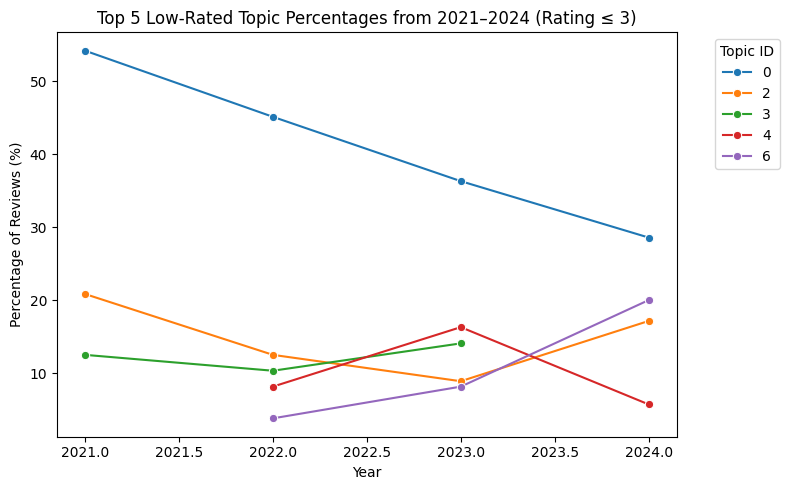

In [ ]:
# Exclude topic -1
df_filtered = df_slice_multiple_years[df_slice_multiple_years['topic'] != -1]

# Find topics with average rating ≤ 3
low_rating_topics = df_filtered.groupby('topic')['rating'].mean()
low_rating_topics = low_rating_topics[low_rating_topics <= 3].index

# Filter for low-rating topics only
df_low_rating = df_filtered[df_filtered['topic'].isin(low_rating_topics)]

# Count topic occurrences per year
topic_freq = df_low_rating.groupby(['year', 'topic']).size().reset_index(name='count')

# Calculate total reviews per year
total_reviews_per_year = df_low_rating.groupby('year')['topic'].count().reset_index(name='total_reviews')

# Merge the total reviews back to the topic_freq dataframe
topic_freq = topic_freq.merge(total_reviews_per_year, on='year')

# Calculate percentage of reviews for each topic
topic_freq['percentage'] = (topic_freq['count'] / topic_freq['total_reviews']) * 100

# Select top 10 most frequent of those low-rating topics
top_topics = topic_freq.groupby('topic')['count'].sum().nlargest(10).index

# Filter again to just top ones
top_topic_freq = topic_freq[topic_freq['topic'].isin(top_topics)]

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=top_topic_freq, x='year', y='percentage', hue='topic', marker='o', palette='tab10')
plt.title("Top 10 Low-Rated Topic Percentages from 2021–2024 (Rating ≤ 3)")
plt.xlabel("Year")
plt.ylabel("Percentage of Reviews (%)")
plt.legend(title='Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Filter topic 0 reviews
topic_0_reviews = df_slice_multiple_years[df_slice_multiple_years['topic'] == 0]

# Combine all clean text into one string
all_words = " ".join(topic_0_reviews['clean_text'])

# Tokenize into individual words
words = all_words.split()

# Count word frequencies
word_freq = Counter(words)

# Display top 30 most common words
top_words = word_freq.most_common(30)
for word, count in top_words:
    print(f"{word}: {count}")


singapore: 341
airline: 320
flight: 296
service: 130
ticket: 123
customer: 114
time: 89
would: 83
u: 80
day: 79
call: 77
back: 73
one: 71
hour: 67
get: 67
change: 67
never: 66
booking: 60
booked: 55
refund: 55
2: 50
luggage: 49
experience: 48
called: 48
phone: 47
told: 47
said: 45
email: 44
airport: 43
seat: 43


In [ ]:

# Filter Topic 0 reviews
topic_0_reviews = df_slice_multiple_years[df_slice_multiple_years['topic'] == 0]

# Get raw text (original, not preprocessed)
text_data = topic_0_reviews['text'].dropna().tolist()

# Extract sentences containing the word "service"
service_sentences = []

for review in text_data:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        if 'service' in sentence.lower():
            service_sentences.append(sentence.strip())

# Display results (you can adjust how many you want to see)
for i, sentence in enumerate(service_sentences[:50], 1):
    print(f"{i}. {sentence}\n")


1. Respected Faculty, I am Bincy, writing this  to file a complaint regarding a cancellation of the connection flight of Singapore airlines and the irresponsible service from Singapore airlines airport staff members at Singapore .My parents 67 yr old Dad as 63 yr old Mom travelled from Brisbane airport in Singapore airlines  SQ236 yesterday at 14.45 hrs and arrived at Singapore airport at 20.25hrs yesterday late evening.

2. They didn't get any emotional or physical support from staffs at Singapore airport.They didn't arrange any room to rest or any proper lounge and not even any food for 24 hours (my parents were not prepared to stay at airport for more than 4 hours as  we booked the tickets with least transit time at Singapore airport)
We had a trust in the services of Singapore airlines, and so we booked the flight for our parents with much confidence.

3. Service is very poorly/not existant.

4. No service orientation.

5. SQ may be a good carrier if everything works out well, but 

In [ ]:
# Filter topic 3 reviews
topic_3_reviews = df_slice_multiple_years[df_slice_multiple_years['topic'] == 3]

# Combine all clean text into one string
all_words = " ".join(topic_3_reviews['clean_text'])

# Tokenize into individual words
words = all_words.split()

# Count word frequencies
word_freq = Counter(words)

# Display top 30 most common words
top_words = word_freq.most_common(30)
for word, count in top_words:
    print(f"{word}: {count}")

flight: 196
singapore: 172
airline: 139
time: 74
u: 73
hour: 67
service: 61
would: 61
luggage: 55
back: 55
one: 54
said: 50
sq: 47
day: 46
seat: 46
told: 46
get: 41
could: 40
even: 39
staff: 39
crew: 38
call: 37
customer: 35
airport: 34
also: 33
ticket: 33
email: 32
never: 31
lounge: 31
meal: 30


In [ ]:
# Filter Topic 2 reviews
topic_3_reviews = df_slice_multiple_years[df_slice_multiple_years['topic'] == 3]

# Get raw text (original, not preprocessed)
text_data = topic_3_reviews['text'].dropna().tolist()

# Extract sentences containing the word "luggage"# Get raw text (original, not preprocessed)
text_data = df_slice_multiple_years['text'].dropna().tolist()

# Extract sentences containing the word "seat"
seat_sentences = []

for review in text_data:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        if 'seat' in sentence.lower():
            seat_sentences.append(sentence.strip())

# Display results (you can adjust how many you want to see)
for i, sentence in enumerate(seat_sentences[:50], 1):
    print(f"{i}. {sentence}\n")

luggage_sentences = []

for review in text_data:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        if 'luggage' in sentence.lower():
            luggage_sentences.append(sentence.strip())

# Display results (you can adjust how many you want to see)
for i, sentence in enumerate(luggage_sentences[:50], 1):
    print(f"{i}. {sentence}\n")


1. We were in premium economy which was spacious, two seats on either side of the plane and 3 seats in the middle.

2. Legroom was good, seats were wider and had bigger arm rest in between the two seats which had the fold away tray tables in.

3. Overall the flight was ok, seats were comfy, legroom good.

4. She was very knowledgeable about the configurations in the A380 aircraft and even pointed to the best seats in each cabin class as we walked through.

5. The table can be swivelled for passengers to get in and out of the seat without stowing it away.

6. The seat was the first thing that caught my eye when I entered my Suite and is very comfortable.

7. An oversized pillow is placed onto the seat to provide passengers with greater comfort, especially in reclined mode.

8. The seat measures 35" wide and can recline up to 45°.

9. The calf rest of the seat can only be deployed when the seat is swivelled to face the TV or the front of the aircraft (the green light on the control panel

In [ ]:
# Filter topic 4 reviews
topic_4_reviews = df_slice_multiple_years[df_slice_multiple_years['topic'] == 4]

# Combine all clean text into one string
all_words = " ".join(topic_4_reviews['clean_text'])

# Tokenize into individual words
words = all_words.split()

# Count word frequencies
word_freq = Counter(words)

# Display top 30 most common words
top_words = word_freq.most_common(30)
for word, count in top_words:
    print(f"{word}: {count}")

singapore: 40
airline: 39
day: 24
flight: 23
luggage: 23
bag: 15
lost: 15
u: 14
service: 14
baggage: 13
call: 13
customer: 12
never: 12
back: 10
airport: 8
experience: 7
told: 7
would: 7
phone: 7
thing: 6
still: 6
3: 6
email: 6
trip: 6
put: 6
get: 6
care: 5
went: 5
time: 5
also: 5


**Given those results ets look more closely into key words to see what are the main problems within those topics**

In [ ]:
# Filter reviews that mention "service" (case-insensitive)
service_reviews = df_slice_multiple_years[df_slice_multiple_years['text'].str.contains(r'\bservice\b', case=False, na=False)]

# Calculate average rating
average_rating_service = service_reviews['rating'].mean()

print(f"Average rating for reviews mentioning 'service': {average_rating_service:.2f}")


Average rating for reviews mentioning 'service': 2.46


In [ ]:
num_service_reviews = service_reviews.shape[0]
print(f"The phrase 'service' appears in {num_service_reviews} reviews.")

The phrase 'service' appears in 673 reviews.


In [ ]:
# Filter reviews that mention the exact phrase "customer service" (case-insensitive)
customer_service_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("customer service", case=False, na=False)
]
# Calculate average rating
avg_rating_cs = customer_service_reviews['rating'].mean()

print(f"Average rating for reviews mentioning 'customer service': {avg_rating_cs:.2f}")


Average rating for reviews mentioning 'customer service': 1.49


In [ ]:
# Count the number of reviews that mention 'customer service'
num_customer_service_reviews = customer_service_reviews.shape[0]

print(f"The phrase 'customer service' appears in {num_customer_service_reviews} reviews.")


The phrase 'customer service' appears in 209 reviews.


In [ ]:
# Filter reviews that mention the word meal(case-insensitive)
meal_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("meal", case=False, na=False)
]
# Calculate average rating
avg_rating_meal = meal_reviews['rating'].mean()

print(f"Average rating for reviews mentioning 'meal': {avg_rating_meal:.2f}")

Average rating for reviews mentioning 'meal': 2.83


In [ ]:
# Count the number of reviews that mention 'meal'
num_meal_reviews = meal_reviews.shape[0]

print(f"The word 'meal' appears in {num_meal_reviews} reviews.")

The word 'meal' appears in 258 reviews.


In [ ]:
# Filter reviews that mention the word food (case-insensitive)
food_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("food", case=False, na=False)
]
# Calculate average rating
avg_rating_cs = food_reviews['rating'].mean()

print(f"Average rating for reviews mentioning 'food': {avg_rating_cs:.2f}")

Average rating for reviews mentioning 'food': 3.00


In [ ]:
# Count the number of reviews that mention 'food'
food_reviews = food_reviews.shape[0]

print(f"The phrase 'food' appears in {food_reviews} reviews.")


The phrase 'food' appears in 435 reviews.


In [ ]:
# Filter reviews that mention the word hour (case-insensitive)
hour_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("hour", case=False, na=False)
]
# Calculate average rating
avg_rating_hour = hour_reviews['rating'].mean()

print(f"Average rating for reviews mentioning 'hour': {avg_rating_hour:.2f}")

Average rating for reviews mentioning 'hour': 2.14


In [ ]:
# Count the number of reviews that mention 'hour'
hour_reviews = hour_reviews.shape[0]

print(f"The phrase 'hour' appears in {hour_reviews} reviews.")

The phrase 'hour' appears in 397 reviews.


In [ ]:
# Filter reviews that mention both 'hour' and 'time' (case-insensitive)
hour_time_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("hour", case=False, na=False) &
    df_slice_multiple_years['text'].str.contains("time", case=False, na=False)
]

# Calculate average rating
avg_rating_hour_time = hour_time_reviews['rating'].mean()

print(f"Average rating for reviews mentioning both 'hour' and 'time': {avg_rating_hour_time:.2f}")


Average rating for reviews mentioning both 'hour' and 'time': 2.03


In [ ]:
# Count the number of reviews that mention both 'hour' and 'time'
hour_time_reviews_count = hour_time_reviews.shape[0]

print(f"The words 'hour' and 'time' both appear in {hour_time_reviews_count} reviews.")


The words 'hour' and 'time' both appear in 198 reviews.


could hour and time be talking about delays??

In [ ]:
# Match words like delay, delayed, delays, delaying
delay_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains(r"\bdelay\w*", case=False, na=False)
]

# Calculate average rating
avg_rating_delay = delay_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'delay': {avg_rating_delay:.2f}")


Average rating for reviews mentioning 'delay': 1.88


In [ ]:
count_delay = delay_reviews.shape[0]
print(f"The word 'delay' (or variation) appears in {count_delay} reviews.")


The word 'delay' (or variation) appears in 91 reviews.


In [ ]:
# Filter reviews that mention the word change (case-insensitive)
change_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains(r"\bchang\w*", case=False, na=False)
]
# Calculate average rating
avg_rating_change = change_reviews['rating'].mean()

print(f"Average rating for reviews mentioning 'change': {avg_rating_change:.2f}")

Average rating for reviews mentioning 'change': 2.00


In [ ]:
# Count the number of reviews that mention change
change_reviews_count = change_reviews.shape[0]

print(f"The word 'change' appear in {change_reviews_count} reviews.")

The word 'change' appear in 270 reviews.


In [ ]:
# Match words like cancel, cancelled, cancelling, cancellation
cancel_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains(r"\bcancel\w*", case=False, na=False)
]

# Calculate average rating
avg_rating_cancel = cancel_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'cancel': {avg_rating_cancel:.2f}")


Average rating for reviews mentioning 'cancel': 1.51


In [ ]:
# Count the number of reviews that mention cancel
cancel_reviews_count = cancel_reviews.shape[0]

print(f"The word 'cancel' appear in {cancel_reviews_count} reviews.")

The word 'cancel' appear in 154 reviews.


In [ ]:
# Match the word "refund" (case-insensitive)
refund_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("refund", case=False, na=False)
]

# Calculate average rating
avg_rating_refund = refund_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'refund': {avg_rating_refund:.2f}")


Average rating for reviews mentioning 'refund': 1.34


In [ ]:
# Count the number of reviews that mention refund
refund_reviews_count = refund_reviews.shape[0]

print(f"The word 'refund' appeara in {refund_reviews_count} reviews.")

The word 'refund' appeara in 123 reviews.


In [ ]:
# Match the phrase "business class" (case-insensitive)
business_class_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("business class", case=False, na=False)
]

# Calculate average rating
avg_rating_business_class = business_class_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'business class': {avg_rating_business_class:.2f}")

Average rating for reviews mentioning 'business class': 2.56


In [ ]:
count_business_class= business_class_reviews.shape[0]
print(f"The phrase 'business class' appears in {count_business_class} reviews.")


The phrase 'business class' appears in 179 reviews.


**lets see some comments about business class**

In [ ]:
# Get raw text (original, not preprocessed)
text_data = df_slice_multiple_years['text'].dropna().tolist()

# Extract sentences containing the phrase "business class"
business_class_sentences = []

for review in text_data:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        if 'business class' in sentence.lower():
            business_class_sentences.append(sentence.strip())

# Display results (you can adjust how many you want to see)
for i, sentence in enumerate(business_class_sentences[:50], 1):
    print(f"{i}. {sentence}\n")


1. Only 5 counters for economy class and 2 for business class.

2. star alliance members have designated line and boarded after business class.

3. No lounge for Premium Economy, only Business class.

4. He ended up with  a couple of crackers  and a slice of cheese, this was his business class meal.

5. I have flown many business class flights on 5-star airlines such as Cathay Pacific, Qatar Airways, and Korean Air.

6. However, on long-haul flights, Singapore Airlines' business class B777-300ER has great service, seats, and food onboard.

7. I  had actually upgraded the long first leg, Manchester to Singapore to business class...food and service was top class for this and I actually found the seat pretty comfortable for sitting...but as you will read elsewhere, the bizarre angle of the footwell makes achieving a comfortable sleeping position nigh on impossible.

8. No amenities kit for business class.

9. This was definitely not my expectation of Business Class, and, as we are 71 and 

In [ ]:
# Match the phrase "seat" (case-insensitive)
seat_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("seat", case=False, na=False)
]

# Calculate average rating
avg_rating_seat = seat_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'seat': {avg_rating_seat:.2f}")

Average rating for reviews mentioning 'seat': 2.75


In [ ]:
count_seat= seat_reviews.shape[0]
print(f"The word 'seat' appears in {count_seat} reviews.")


The word 'seat' appears in 469 reviews.


**lets see some comments about 'seat'**

In [ ]:
# Get raw text (original, not preprocessed)
text_data = df_slice_multiple_years['text'].dropna().tolist()

# Extract sentences containing the word "seat"
seat_sentences = []

for review in text_data:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        if 'seat' in sentence.lower():
            seat_sentences.append(sentence.strip())

# Display results (you can adjust how many you want to see)
for i, sentence in enumerate(seat_sentences[:50], 1):
    print(f"{i}. {sentence}\n")


1. We were in premium economy which was spacious, two seats on either side of the plane and 3 seats in the middle.

2. Legroom was good, seats were wider and had bigger arm rest in between the two seats which had the fold away tray tables in.

3. Overall the flight was ok, seats were comfy, legroom good.

4. She was very knowledgeable about the configurations in the A380 aircraft and even pointed to the best seats in each cabin class as we walked through.

5. The table can be swivelled for passengers to get in and out of the seat without stowing it away.

6. The seat was the first thing that caught my eye when I entered my Suite and is very comfortable.

7. An oversized pillow is placed onto the seat to provide passengers with greater comfort, especially in reclined mode.

8. The seat measures 35" wide and can recline up to 45°.

9. The calf rest of the seat can only be deployed when the seat is swivelled to face the TV or the front of the aircraft (the green light on the control panel

In [ ]:
# Match the phrase "premium economy" (case-insensitive)
premium_economy_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("premium economy", case=False, na=False)
]

# Calculate average rating
avg_rating_premium_economy = premium_economy_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'premium economy': {avg_rating_premium_economy:.2f}")

# Count reviews mentioning "premium economy"
count_premium_economy = premium_economy_reviews.shape[0]
print(f"The phrase 'premium economy' appears in {count_premium_economy} reviews.")


Average rating for reviews mentioning 'premium economy': 2.19
The phrase 'premium economy' appears in 108 reviews.


In [ ]:
# Match the phrases "premium economy" and "seat" (case-insensitive)
premium_economy_and_seat_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("premium economy", case=False, na=False) &
    df_slice_multiple_years['text'].str.contains("seat", case=False, na=False)
]

# Calculate average rating
avg_rating_premium_economy_and_seat = premium_economy_and_seat_reviews['rating'].mean()
print(f"Average rating for reviews mentioning both 'premium economy' and 'seat': {avg_rating_premium_economy_and_seat:.2f}")

# Count reviews mentioning both "premium economy" and "seat"
count_premium_economy_and_seat = premium_economy_and_seat_reviews.shape[0]
print(f"The phrase 'premium economy' and 'seat' appear together in {count_premium_economy_and_seat} reviews.")


Average rating for reviews mentioning both 'premium economy' and 'seat': 2.10
The phrase 'premium economy' and 'seat' appear together in 79 reviews.


In [ ]:
 # Match the phrase "business class" (case-insensitive)
business_class_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("business class", case=False, na=False)
]

# Calculate average rating
avg_rating_business_class = business_class_reviews['rating'].mean()
print(f"Average rating for reviews mentioning 'business class': {avg_rating_business_class :.2f}")

# Count reviews mentioning "business class"
count_business_class = business_class_reviews.shape[0]
print(f"The phrase 'business class' appears in {count_business_class} reviews.")

Average rating for reviews mentioning 'business class': 2.56
The phrase 'business class' appears in 179 reviews.


In [ ]:
# Match the phrases "business class" and "seat" (case-insensitive)
business_class_and_seat_reviews = df_slice_multiple_years[
    df_slice_multiple_years['text'].str.contains("business class", case=False, na=False) &
    df_slice_multiple_years['text'].str.contains("seat", case=False, na=False)
]

# Calculate average rating
avg_rating_business_class_and_seat = business_class_and_seat_reviews['rating'].mean()
print(f"Average rating for reviews mentioning both 'business class' and 'seat': {avg_rating_business_class_and_seat:.2f}")

# Count reviews mentioning both "business class" and "seat"
count_business_class_and_seat = business_class_and_seat_reviews.shape[0]
print(f"The phrase 'business class' and 'seat' appear together in {count_business_class_and_seat} reviews.")


Average rating for reviews mentioning both 'business class' and 'seat': 2.76
The phrase 'business class' and 'seat' appear together in 95 reviews.


##lets now plot for better understanding




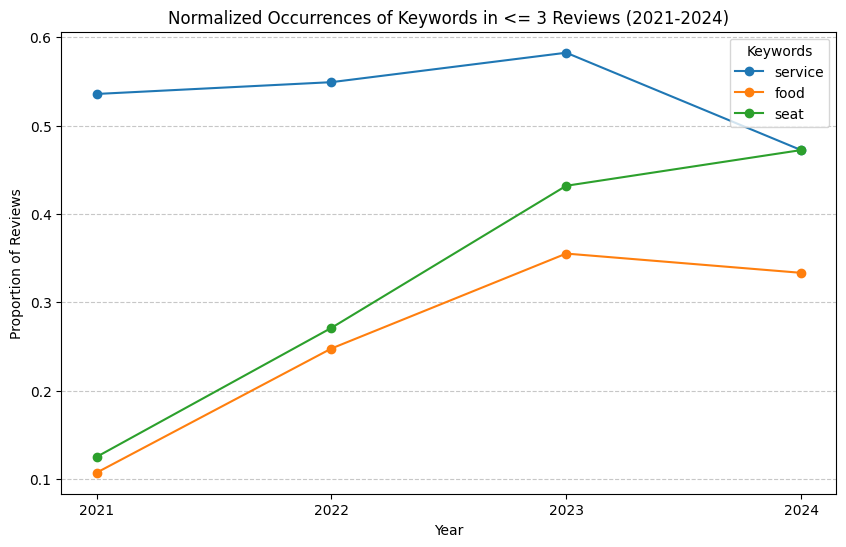

In [ ]:
# Define the words you want to track
keywords = ['service', 'food', 'seat']

# Filter reviews with ratings <= 3
low_rating_reviews = df_slice_multiple_years[df_slice_multiple_years['rating'] <= 3]

# Initialize a dictionary to store normalized counts by year for each keyword
keyword_counts = {keyword: [] for keyword in keywords}
total_reviews_by_year = low_rating_reviews.groupby('year').size()

# Iterate over the keywords and count occurrences by year
for keyword in keywords:
    # Filter reviews containing the keyword (case-insensitive)
    filtered_reviews = low_rating_reviews[
        low_rating_reviews['text'].str.contains(rf"\b{keyword}\w*", case=False, na=False)
    ]

    # Count occurrences by year
    counts_by_year = filtered_reviews.groupby('year').size()

    # Normalize by the total reviews in each year
    for year in range(2021, 2025):  # assuming the years are 2021 to 2024
        total_reviews = total_reviews_by_year.get(year, 0)
        if total_reviews > 0:
            normalized_count = counts_by_year.get(year, 0) / total_reviews
        else:
            normalized_count = 0
        keyword_counts[keyword].append(normalized_count)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each keyword's normalized counts over the years
for keyword, counts in keyword_counts.items():
    plt.plot(range(2021, 2025), counts, marker='o', label=keyword)

# Customize the plot
plt.title("Normalized Occurrences of Keywords in <= 3 Reviews (2021-2024)")
plt.xlabel("Year")
plt.ylabel("Proportion of Reviews")
plt.xticks(range(2021, 2025))
plt.legend(title="Keywords", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()



## Lets now do the same for years 2018, 2019, 2020 (good years) in oder to be able to compare with previus results


In [ ]:
df_slice_multiple_yearsG = df[df['year'].isin([2018,2019,2020])]
df_slice_multiple_yearsG.shape[0]

8732

In [ ]:
# Add suitable embedding
embedding_model_MMG = SentenceTransformer("paraphrase-MiniLM-L12-v2")

# UMAP for dimensionality reduction before clustering
umap_model_MMG = umap.UMAP(n_neighbors=30, n_components=10, min_dist=0.3, metric='euclidean', random_state=42, n_jobs=1)

# Optimize clustering with HDBSCAN
hdbscan_model_MMG = HDBSCAN(min_cluster_size=10, min_samples=3, metric='euclidean', cluster_selection_method='eom')

# Train BERTopic model
topic_model_new_MMG = BERTopic(
    embedding_model=embedding_model_MMG,
    umap_model=umap_model_MMG,
    hdbscan_model=hdbscan_model_MMG,
    n_gram_range=(1, 4),
    vectorizer_model=vectorizer_model,
    top_n_words=30,
    nr_topics='auto',
    verbose=True
)

In [ ]:
topics, probs = topic_model_new_MMG.fit_transform(df_slice_multiple_yearsG['clean_text'])

2025-04-10 12:54:55,982 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

2025-04-10 13:03:26,677 - BERTopic - Embedding - Completed ✓
2025-04-10 13:03:26,679 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-10 13:04:00,579 - BERTopic - Dimensionality - Completed ✓
2025-04-10 13:04:00,581 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-10 13:04:01,756 - BERTopic - Cluster - Completed ✓
2025-04-10 13:04:01,757 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-10 13:04:07,289 - BERTopic - Representation - Completed ✓
2025-04-10 13:04:07,314 - BERTopic - Topic reduction - Reducing number of topics
2025-04-10 13:04:07,333 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-10 13:04:13,267 - BERTopic - Representation - Completed ✓
2025-04-10 13:04:13,292 - BERTopic - Topic reduction - Reduced number of topics from 51 to 11


In [ ]:
topic_model_new_MMG.visualize_barchart()

In [ ]:
# Average rating per topic overall,
df_slice_multiple_yearsG['topic'] = topics
topic_ratings_MYG=df_slice_multiple_yearsG.groupby('topic')['rating'].mean().sort_index()
topic_ratings_MYG

,rating
topic,
-1,4.255559
0,4.182203
1,4.697479
2,4.584615
3,4.622222
4,4.000000
5,4.538462
6,3.894737
7,4.846154


In [ ]:

# View top 10 words for each topic
topics = topic_model_new_MMG.get_topics()
for topic_id, topic in topics.items():
    print(f"Topic {topic_id}: {', '.join([word for word, _ in topic[:10]])}")

Topic -1: service, food, seat, good, time, staff, class, great, meal, economy
Topic 0: seat, service, economy, good, food, time, class, crew, one, staff
Topic 1: food, service, good, great, staff, comfortable, excellent, seat, entertainment, friendly
Topic 2: sia, always, service, best, experience, crew, time, food, good, year
Topic 3: toilet, clean, comfortable, service, good, food, staff, cleaned, friendly, seat
Topic 4: meal, food, service, good, served, drink, diet, staff, cup, meal served
Topic 5: wheelchair, staff, husband, always, mom, boarding, airport, check, service, mobility
Topic 6: sq, time, fly, service, flying sq, better, flying, experience, good, status
Topic 7: wife, anniversary, cake, crew, birthday, special, wedding, mother, honeymoon, made
Topic 8: movie, choice, good, great, drink choice, drink, entertainment, october, great choice, program
Topic 9: red eye, red, eye, breakfast, good, took, sleep, served, comfortable, time


In [ ]:
topic_model_new_MMG.visualize_term_rank()

Lets lable the topics

Topic 0: Seat Comfort & Economy Class Experience

Topic 1: Overall In-Flight Experience & Friendly Staff

Topic 2: Loyalty and Consistently Great Service

Topic 3: Cleanliness & Cabin Comfort

Topic 4: Meal & Food Service

Topic 5: Mobility Assistance & Wheelchair Support

Topic 6: Flying with Singapore Airlines (General Sentiment & Loyalty)

Topic 7: Special Occasions & Personalized Celebrations

Topic 8: Entertainment System & Media Options

Topic 9: Red-Eye Flight Comfort & Sleep Experience

## Lets plot low rated topics. Im doing < 4 as I could not find < 3

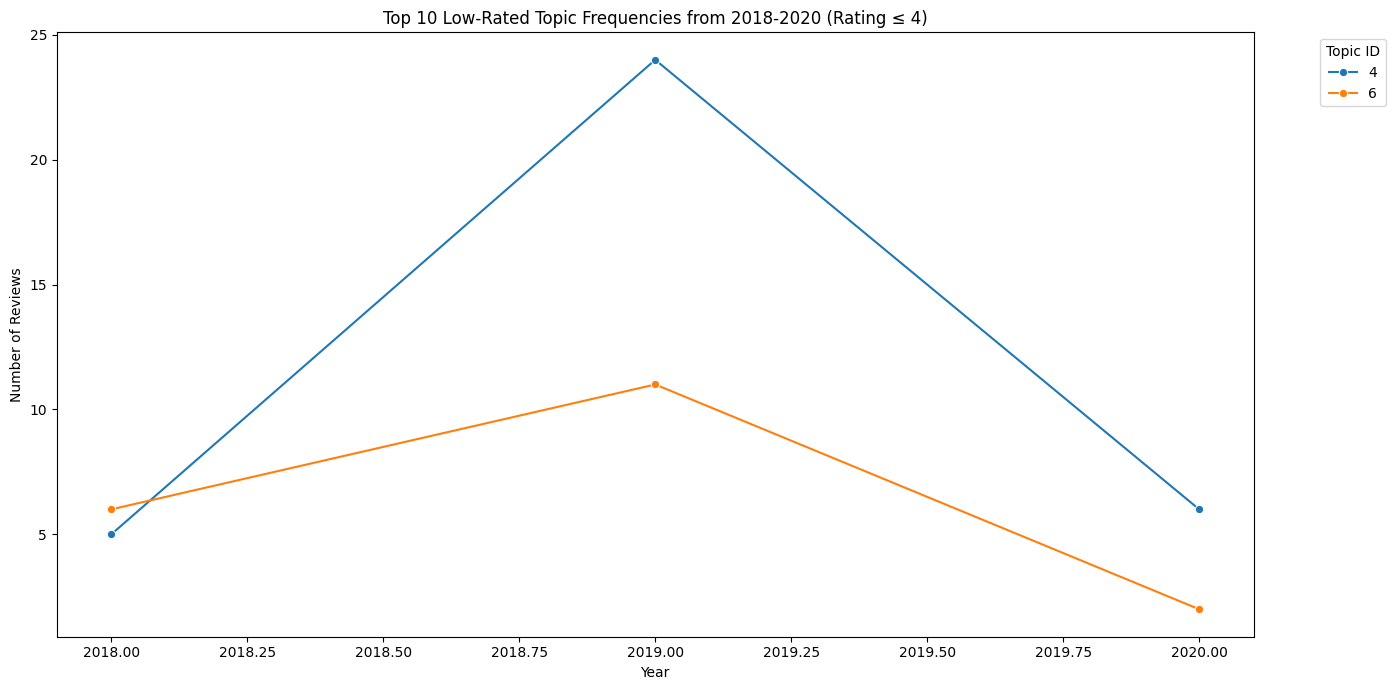

In [ ]:
# Step 1: Exclude topic -1
df_filtered_G = df_slice_multiple_yearsG[df_slice_multiple_yearsG['topic'] != -1]

# Step 2: Find topics with average rating ≤ 4
low_rating_topics_G = df_filtered_G.groupby('topic')['rating'].mean()
low_rating_topics_G = low_rating_topics_G[low_rating_topics_G <= 4].index

# Step 3: Filter for low-rating topics only
df_low_rating_G = df_filtered_G[df_filtered_G['topic'].isin(low_rating_topics_G)]

# Step 4: Count topic occurrences per year
topic_freq_G = df_low_rating_G.groupby(['year', 'topic']).size().reset_index(name='count')

# Step 5: Select top 10 most frequent of those low-rating topics
top_topics_G = topic_freq_G.groupby('topic')['count'].sum().nlargest(10).index

# Step 6: Filter again to just top ones
top_topic_freq_G = topic_freq_G[topic_freq_G['topic'].isin(top_topics_G)]

# Step 7: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=top_topic_freq_G, x='year', y='count', hue='topic', marker='o', palette='tab10')
plt.title("Top 10 Low-Rated Topic Frequencies from 2018-2020 (Rating ≤ 4)")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.legend(title='Topic ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Filter reviews that mention "service" (case-insensitive)
service_reviews_G = df_slice_multiple_yearsG[df_slice_multiple_yearsG['text'].str.contains(r'\bservice\b', case=False, na=False)]

# Calculate average rating
average_rating_service_G = service_reviews_G['rating'].mean()

print(f"Average rating for reviews mentioning 'service': {average_rating_service_G:.2f}")

Average rating for reviews mentioning 'service': 4.31


In [ ]:
num_service_reviews_G = service_reviews_G.shape[0]
print(f"The phrase 'service' appears in {num_service_reviews_G} reviews.")

The phrase 'service' appears in 4417 reviews.


In [ ]:
# Filter reviews that mention the exact phrase "customer service" (case-insensitive)
customer_service_reviews_G = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("customer service", case=False, na=False)
]
# Calculate average rating
avg_rating_cs_G = customer_service_reviews_G['rating'].mean()

print(f"Average rating for reviews mentioning 'customer service': {avg_rating_cs_G:.2f}")


Average rating for reviews mentioning 'customer service': 3.64


In [ ]:
# Count the number of reviews that mention 'customer service'
num_customer_service_reviews_G = customer_service_reviews_G.shape[0]

print(f"The phrase 'customer service' appears in {num_customer_service_reviews_G} reviews.")

The phrase 'customer service' appears in 299 reviews.


In [ ]:
# Filter reviews that mention the word food (case-insensitive)
food_reviews_G = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("food", case=False, na=False)
]
# Calculate average rating
avg_rating_food_G = food_reviews_G['rating'].mean()

print(f"Average rating for reviews mentioning 'food': {avg_rating_food_G:.2f}")

Average rating for reviews mentioning 'food': 4.31


In [ ]:
# Count the number of reviews that mention 'food'
food_reviews_G = food_reviews_G.shape[0]

print(f"The phrase 'food' appears in {food_reviews_G} reviews.")


The phrase 'food' appears in 4151 reviews.


In [ ]:
# Filter reviews that mention the word meal (case-insensitive)
meal_reviews_G = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("meal", case=False, na=False)
]
# Calculate average rating
avg_rating_meal_G = meal_reviews_G['rating'].mean()

print(f"Average rating for reviews mentioning 'meal': {avg_rating_meal_G:.2f}")

Average rating for reviews mentioning 'meal': 4.19


In [ ]:
# Count the number of reviews that mention 'meal'
meal_reviews_G = meal_reviews_G.shape[0]

print(f"The phrase 'meal' appears in {meal_reviews_G} reviews.")


The phrase 'meal' appears in 1737 reviews.


In [ ]:
# Filter reviews that mention the luggage (case-insensitive)
luggage_reviews_G = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("luggage", case=False, na=False)
]
# Calculate average rating
avg_rating_luggage_G = luggage_reviews_G['rating'].mean()

print(f"Average rating for reviews mentioning 'luggage': {avg_rating_luggage_G:.2f}")

Average rating for reviews mentioning 'luggage': 3.93


In [ ]:
# Count the number of reviews that mention 'luggage'
luggage_reviews_G = luggage_reviews_G.shape[0]

print(f"The phrase 'luggage' appears in {luggage_reviews_G} reviews.")


The phrase 'luggage' appears in 328 reviews.


In [ ]:
# Match words like cancel, cancelled, cancelling, cancellation
cancel_reviewsG = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains(r"\bcancel\w*", case=False, na=False)
]

# Calculate average rating
avg_rating_cancelG = cancel_reviewsG['rating'].mean()
print(f"Average rating for reviews mentioning 'cancel': {avg_rating_cancelG:.2f}")

Average rating for reviews mentioning 'cancel': 3.11


In [ ]:
# Count the number of reviews that mention cancel
cancel_reviews_countG = cancel_reviewsG.shape[0]

print(f"The word 'cancel' appear in {cancel_reviews_countG} reviews.")

The word 'cancel' appear in 230 reviews.


In [ ]:
# Match words like delay, delayed, delays, delaying
delay_reviewsG = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains(r"\bdelay\w*", case=False, na=False)
]

# Calculate average rating
avg_rating_delayG = delay_reviewsG['rating'].mean()
print(f"Average rating for reviews mentioning 'delay': {avg_rating_delayG:.2f}")

Average rating for reviews mentioning 'delay': 3.82


In [ ]:
count_delayG = delay_reviewsG.shape[0]
print(f"The word 'delay' (or variation) appears in {count_delayG} reviews.")


The word 'delay' (or variation) appears in 363 reviews.


In [ ]:
# Match the word "refund" (case-insensitive)
refund_reviewsG = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("refund", case=False, na=False)
]

# Calculate average rating
avg_rating_refundG = refund_reviewsG['rating'].mean()
print(f"Average rating for reviews mentioning 'refund': {avg_rating_refundG:.2f}")



Average rating for reviews mentioning 'refund': 2.38


In [ ]:
# Count the number of reviews that mention refund
refund_reviews_countG = refund_reviewsG.shape[0]

print(f"The word 'refund' appeara in {refund_reviews_countG} reviews.")

The word 'refund' appeara in 116 reviews.


In [ ]:
# Match the phrase "seat" (case-insensitive)
seat_reviewsG = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("seat", case=False, na=False)
]

# Calculate average rating
avg_rating_seatG = seat_reviewsG['rating'].mean()
print(f"Average rating for reviews mentioning 'seat': {avg_rating_seatG:.2f}")

Average rating for reviews mentioning 'seat': 4.10


In [ ]:
count_seatG= seat_reviewsG.shape[0]
print(f"The word 'seat' appears in {count_seatG} reviews.")

The word 'seat' appears in 3430 reviews.


In [ ]:
# Match the phrase "premium economy" (case-insensitive)
premium_economy_reviewsG = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("premium economy", case=False, na=False)
]

# Calculate average rating
avg_rating_premium_economyG = premium_economy_reviewsG['rating'].mean()
print(f"Average rating for reviews mentioning 'premium economy': {avg_rating_premium_economyG:.2f}")

# Count reviews mentioning "premium economy"
count_premium_economyG = premium_economy_reviewsG.shape[0]
print(f"The phrase 'premium economy' appears in {count_premium_economyG} reviews.")


Average rating for reviews mentioning 'premium economy': 3.90
The phrase 'premium economy' appears in 683 reviews.


In [ ]:
 # Match the phrase "business class" (case-insensitive)
business_class_reviewsG = df_slice_multiple_yearsG[
    df_slice_multiple_yearsG['text'].str.contains("business class", case=False, na=False)
]

# Calculate average rating
avg_rating_business_classG = business_class_reviewsG['rating'].mean()
print(f"Average rating for reviews mentioning 'business class': {avg_rating_business_classG:.2f}")

# Count reviews mentioning "business class"
count_business_classG = business_class_reviewsG.shape[0]
print(f"The phrase 'business class' appears in {count_business_classG} reviews.")


Average rating for reviews mentioning 'business class': 4.10
The phrase 'business class' appears in 979 reviews.


##Additional plots that i will include in my slides:

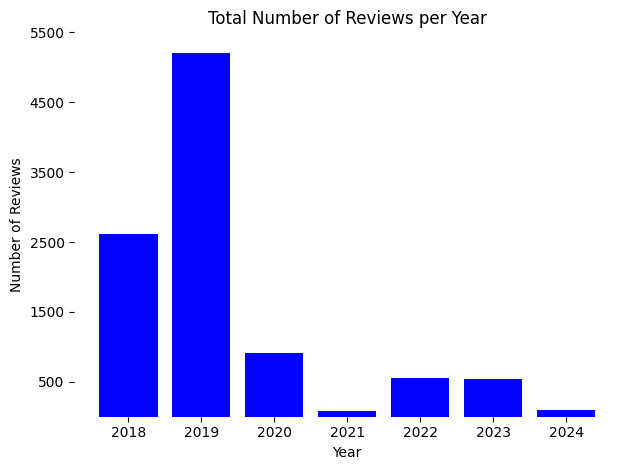

In [ ]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
review_counts = [2618, 5203, 911, 85, 552, 535, 96]


plt.bar(years, review_counts, color='blue')
plt.title('Total Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(years)
plt.yticks(range(500, max(review_counts) + 1000, 1000))
plt.grid(False)
plt.box(False)
plt.tight_layout()
plt.show()

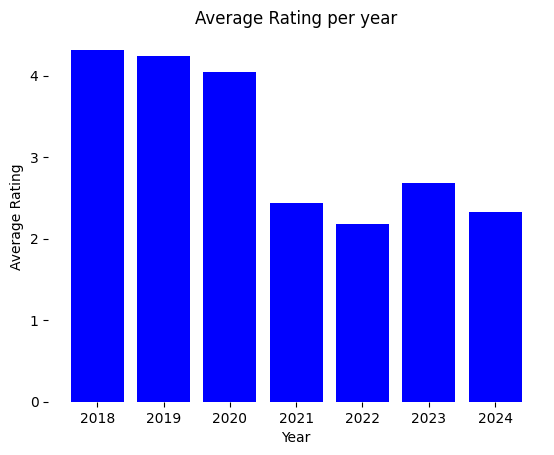

In [ ]:
plt.bar(aggregated_data['year'], aggregated_data['rating'], color='blue')

plt.title('Average Rating per year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.box(False)
plt.show()

#**Key Recommendations to Singapore Airlines’ CEO**
**1. Prioritize Enhancing Customer Service**

**Recommendation:**

Enhance response times and agent effectiveness to address customer frustrations. This includes investing in improved ticketing portals, smart self-service options (e.g., chatbots), and better-trained support agents.

**Rationale:**

Customer service is by far the most dominant and persistent concern across low-rated reviews (especially Topic 0). Issues such as unresponsive agents, poor communication, and difficulty resolving ticketing or refund problems have been a consistent pain point since 2021. While there has been a slight decline in volume over time, it still appears in a significant percentage of negative reviews. By modernizing support systems and ensuring agent responsiveness, Singapore Airlines can significantly reduce friction in the customer journey, leading to higher satisfaction, fewer complaints, and a stronger post-COVID service reputation.

**2. Focus on Seat & Cabin Comfort**

**Recommendation:**

Take immediate action to address the rising concerns related to Seat & Cabin Comfort, especially in premium economy, where cutomers expectations are higher as they are paying for an upgraded experience. This includes improving seat space, legroom, design, and overall comfort.

**Rationale:**

Complaints related to seating have risen sharply in 2024. While mentions remained stable overall (36%–39%), negative mentions rose dramatically, from 0.12 in 2021 to 0.47 in 2024. This signals increasing dissatisfaction in a key area of the passenger experience. Reviews specifically mention that Singapore Airlines' premium economy lags behind competitors like Air New Zealand and Virgin in comfort. By upgrading this offering, the airline can better meet rising customer expectations and prevent seat-related complaints from overtaking service issues as the top dissatisfaction driver.

**3. Improve In-Flight Meal Quality**

**Recommendation:** Reassess and enhance the quality of in-flight meals by introducing healthier and more diverse meal options. Additionally, ensure consistent quality control and focus on customer preferences.

**Rationale:**

Food-related issues (Topic 4) became increasingly visible in low-rated reviews during 2022–2023. Ratings for "food" dropped from 4.31 to 3.00, while “meal” ratings fell from 4.19 to 2.83. Customers noted a decline in both quality and variety, particularly after in-flight services resumed post-pandemic. Investing in better meals not only improves the overall flight experience but also signals a return to the airline’s high-quality standards. Regular surveys and menu innovation can help maintain excellence in this often-overlooked area of differentiation.

**4. Rebuild Customer Engagement and Encourage Feedback**

**Recommendation:**

Develop a strategy to encourage more customer feedback, such as personalized post-flight surveys and incentivizing reviews. Additionally, focus on rebuilding customer trust through targeted marketing campaigns that highlight service improvements.

**Rationale:**

The total number of reviews dropped by ~85% post-2020, indicating a concerning dip in engagement. Fewer reviews limit the airline’s visibility into evolving customer sentiment and reduce opportunities to connect with passengers post-flight. Re-engaging customers with smart, timely requests for feedback, and showing them that their voices are being heard—will help rebuild loyalty and close the feedback loop. Marketing efforts should focus on reinforcing recent service improvements to drive renewed trust.

**5. Monitor and Respond to Emerging 2024 Trends**

**Recommendation:**

Continue monitoring 2024 data as more reviews come in to identify any shifts in customer sentiment. Adapt strategies accordingly to stay responsive to changing customer needs and expectations.

**Rationale:**

The data for 2024 is still incomplete, with only 96 reviews available. As more reviews come in, trends may shift, particularly regarding Topic 6 and other emerging concerns. It's important to remain agile and responsive to changes in customer preferences and complaints, ensuring that the airline can adjust its offerings in real-time to align with customer demands.


Together, these recommendations are built to help Singapore Airlines regain its premium standing in the post-pandemic travel landscape by directly addressing the most impactful areas of customer dissatisfaction.